In [1]:
# from pathlib import PurePath
# import os
# import sys
# os.chdir(PurePath(os.path.abspath('')).parent)
# sys.path.append(os.getcwd())

In [1]:
import json
from qmap.toolkit import clustering
from qmap.toolkit import aligner
from qmap.toolkit import split
import igraph as ig
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from transformers import EsmTokenizer, EsmModel
from pyutils import progress
from sklearn.linear_model import LinearRegression
from pyutils import Colors
from split_utils import read_fasta
import pickle

/Users/anthonylavertu/mac_docs/pycharmProjects/QMAP/split_experiment/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open('../data/build/dataset.json', 'r') as f:
    dataset = json.load(f)
dataset = [sample for sample in dataset if len(sample['Sequence']) <= 100]
dataset[0].keys()

dict_keys(['ID', 'Sequence', 'N Terminus', 'N Terminus Name', 'C Terminus', 'C Terminus Name', 'Unusual Amino Acids', 'Unusual Amino Acids Names', 'Targets', 'Hemolitic Activity', 'Cytotoxic Activity'])

In [3]:
def cluster_deviation(df, dataset, target = "Escherichia coli"):
    deviation = []
    for cluster in df['community'].unique():
        ids = df[df['community'] == cluster]['node_id'].values
        mic_values = [dataset[idx]['Targets'][target] for idx in ids if target in dataset[idx]['Targets'] and not np.isinf(dataset[idx]['Targets'][target])]
        if len(mic_values) > 1:
            deviation.append(np.std(mic_values))
    return np.quantile(deviation, [0.1, 0.25, 0.5, 0.75, 0.9]), np.mean(deviation)

In [ ]:
encoder = aligner.Encoder()
vectorDB = encoder.encode([seq['Sequence'] for seq in dataset])

In [ ]:
line10, line25, line50, line75, line90, means = [], [], [], [], [], []
thresholds = [0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
for threshold in thresholds:
    path, _ = clustering.build_graph(vectorDB, threshold=threshold)
    graph = ig.Graph.Read_Edgelist(path, directed=False)
    df = clustering.leiden_community_detection(graph)
    quantiles, mean = cluster_deviation(df, dataset)
    line10.append(quantiles[0])
    line25.append(quantiles[1])
    line50.append(quantiles[2])
    line75.append(quantiles[3])
    line90.append(quantiles[4])
    means.append(mean)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the median line (50th percentile)
ax.plot(thresholds, line50, color='black', linewidth=2, label='Median (50th percentile)')
ax.plot(thresholds, means, color='tab:orange', linestyle='--', label='Mean')
# Fill between 10th and 90th percentiles (lighter shading)
ax.fill_between(thresholds, line10, line90,
                alpha=0.2, color='tab:blue', label='10th-90th percentile')

# Fill between 25th and 75th percentiles (darker shading)
ax.fill_between(thresholds, line25, line75,
                alpha=0.4, color='tab:blue', label='25th-75th percentile')

# Customize the plot
ax.set_xlabel('Thresholds')
ax.set_ylabel('Values')
# ax.set_ylim([0, 1700])
# ax.set_yscale('log')
ax.set_title('Quantile Plot with Median Line and Confidence Intervals')
ax.legend()
ax.grid(True, alpha=0.3)

# Display the plot
plt.tight_layout()

In [ ]:
df = pd.DataFrame({
        'Threshold': thresholds,
        '10th Percentile': line10,
        '25th Percentile': line25,
        'Median (50th)': line50,
        '75th Percentile': line75,
        '90th Percentile': line90,
        'Mean': means
    })
df

In [ ]:
alignment = aligner.align_db(vectorDB, vectorDB)
alignment_matrix = alignment.alignment_matrix

In [ ]:
ecoli_mic = np.log10([sample['Targets']['Escherichia coli'] if 'Escherichia coli' in sample['Targets'] else np.nan for sample in dataset])

In [ ]:
dist = np.abs(ecoli_mic[:, None] - ecoli_mic[None, :])
# Replace inf with nan
dist[np.isinf(dist)] = np.nan

In [ ]:
# COmpute the correlation between the alignment matrix and the distance matrix by ignoring nans
mask = np.logical_and(np.logical_and(~np.isnan(dist), ~np.isinf(dist)), alignment_matrix > 0.75)
correlation = np.corrcoef(alignment_matrix[mask], dist[mask])

In [ ]:
print(correlation)

In [ ]:
plt.scatter(alignment_matrix[mask], dist[mask], alpha=0.1)

In [ ]:
spread = []
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for t in thresholds:
    mask = np.logical_and(alignment_matrix > t, alignment_matrix < t + 0.5)
    spread.append(np.nanmean(dist[mask]))
plt.plot(thresholds, spread, marker='o', label='Spread of alignments')

# ML prediction
To assert the best splitting threshold, we will generate embeddings using ESM2 650M and use a linear regressor to predict the log MIC values. We will try different thresholds and plot the test performances.

In [3]:
def generate_esm2_embeddings(protein_sequences: list[str],
                             model_name: str = "facebook/esm2_t33_650M_UR50D",
                             device: str = None,
                             batch_size: int = 1) -> np.ndarray:
    """
    Generate protein embeddings using ESM2 model with mean pooling.

    Args:
        protein_sequences (List[str]): List of protein sequences (amino acid sequences)
        model_name (str): Name of the ESM2 model to use. Options include:
            - "facebook/esm2_t6_8M_UR50D" (8M parameters)
            - "facebook/esm2_t12_35M_UR50D" (35M parameters)
            - "facebook/esm2_t30_150M_UR50D" (150M parameters)
            - "facebook/esm2_t33_650M_UR50D" (650M parameters) - default
            - "facebook/esm2_t36_3B_UR50D" (3B parameters)
            - "facebook/esm2_t48_15B_UR50D" (15B parameters)
        device (str): Device to run the model on ('cuda', 'cpu', or None for auto-detection)
        batch_size (int): Batch size for processing sequences

    Returns:
        np.ndarray: Array of shape (num_sequences, embedding_dim) containing embeddings
                   in the same order as input sequences
    """

    # Set device
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Load tokenizer and model
    tokenizer = EsmTokenizer.from_pretrained(model_name)
    model = EsmModel.from_pretrained(model_name)
    model.to(device)
    model.eval()

    all_embeddings = []

    # Process sequences in batches
    for i in progress(range(0, len(protein_sequences), batch_size)):
        batch_sequences = protein_sequences[i:i + batch_size]

        # Tokenize sequences
        inputs = tokenizer(batch_sequences,
                           return_tensors="pt",
                           padding=True,
                           truncation=True,
                           max_length=1024)

        # Move to device
        inputs = {key: value.to(device) for key, value in inputs.items()}

        # Generate embeddings
        with torch.no_grad():
            outputs = model(**inputs)
            hidden_states = outputs.last_hidden_state  # Shape: (batch_size, seq_len, hidden_size)

        # Process each sequence in the batch
        for j in range(len(batch_sequences)):
            # Get attention mask for this sequence (to exclude padding tokens)
            attention_mask = inputs['attention_mask'][j]
            seq_embeddings = hidden_states[j][attention_mask.bool()]  # Remove padding

            # Remove special tokens (CLS and EOS tokens)
            seq_embeddings_no_special = seq_embeddings[1:-1]  # Remove first (CLS) and last (EOS) tokens

            # Mean pooling
            seq_embedding = seq_embeddings_no_special.mean(dim=0)
            all_embeddings.append(seq_embedding.cpu().numpy())

    return np.array(all_embeddings)

In [3]:
# embs = generate_esm2_embeddings([sample["Sequence"] for sample in dataset], batch_size=128, device="mps")
embs = np.load(".cache/esm2_embeddings.npy")

In [5]:
# np.save(".cache/esm2_embeddings.npy", embs)

In [ ]:
thresholds = [0.3, 0.4, 0.5, 0.55, 0.60, 0.65, 0.70, 0.75, 0.8, 0.9, 0.99]
pcc_trains = np.empty((len(thresholds), 5))
pcc_tests = np.empty((len(thresholds), 5))
for i, threshold in enumerate(thresholds):
    for j in range(5 if threshold != 0.3 else 1):
        train_seq, test_seq, train_embs, test_embs, train_samples, test_samples = split.train_test_split(
            [sample["Sequence"] for sample in dataset],
            embs,
            dataset,
            threshold=threshold,
            post_filtering=True,
            n_iterations=2
        )
        print(f"Train size: {len(train_seq)}, Test size: {len(test_seq)}")
        while len(train_seq) < 3000:
            train_seq, test_seq, train_embs, test_embs, train_samples, test_samples = split.train_test_split(
                [sample["Sequence"] for sample in dataset],
                embs,
                dataset,
                threshold=threshold,
                post_filtering=True,
                n_iterations=2
            )
            print(f"Train size: {len(train_seq)}, Test size: {len(test_seq)}")

        train_y = np.array([sample['Targets']['Escherichia coli'] if 'Escherichia coli' in sample['Targets'] else np.nan for sample in train_samples])
        train_y[np.isinf(train_y)] = np.nan
        mask = ~np.isnan(train_y)
        train_y = np.log10(train_y[mask])
        train_embs = np.array(train_embs)[mask]
        indices = np.arange(len(train_y))
        np.random.shuffle(indices)
        indices = indices[:3000]
        train_y = train_y[indices]
        train_embs = train_embs[indices]

        test_y = np.array([sample['Targets']['Escherichia coli'] if 'Escherichia coli' in sample['Targets'] else np.nan for sample in test_samples])
        test_y[np.isinf(test_y)] = np.nan
        mask = ~np.isnan(test_y)
        test_y = np.log10(test_y[mask])
        test_embs = np.array(test_embs)[mask]

        # Make a linear regression model
        reg = LinearRegression()
        reg.fit(train_embs, train_y)

        pcc_train = np.corrcoef(reg.predict(train_embs), train_y)[0, 1]
        pcc_test = np.corrcoef(reg.predict(test_embs), test_y)[0, 1]
        if threshold == 0.3:
            pcc_trains[i, :] = pcc_train
            pcc_tests[i, :] = pcc_test
        else:
            pcc_trains[i, j] = pcc_train
            pcc_tests[i, j] = pcc_test
        print(f'{Colors.orange} - [it {j}]', threshold, pcc_train, pcc_test, f'{Colors.reset}')

Encoding sequences:   ━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━  8/38 it 1.85 it/s eta 00:16

Text(0.5, 1.0, 'PCC vs splitting threshold')

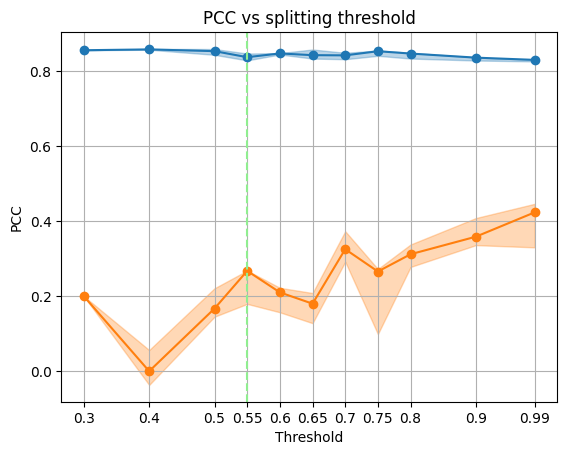

In [33]:
plt.plot(thresholds, np.median(pcc_trains, axis=1), label='Train PCC', marker='o')
plt.plot(thresholds, np.median(pcc_tests, axis=1), label='Test PCC', marker='o')
plt.fill_between(thresholds, np.max(pcc_trains, axis=1), np.min(pcc_trains, axis=1), color="tab:blue", alpha=0.3)
plt.fill_between(thresholds, np.max(pcc_tests, axis=1), np.min(pcc_tests, axis=1), color="tab:orange", alpha=0.3)

# Add a vertical line at the threshold of 0.55
plt.axvline(x=0.55, color='lightgreen', linestyle='--', label='Threshold 0.55')
plt.xlabel('Threshold')
plt.ylabel('PCC')
plt.xticks(thresholds, thresholds)
plt.grid()
plt.title('PCC vs splitting threshold')

In [9]:
# Read the peptide atlas data and we will compare its distance to the DBAASP database to get a sense of the real world distance between sequences
peptide_atlas = read_fasta("../peptide_atlas/.cache/peptide_atlas.fasta")

In [13]:
encoder = aligner.Encoder()
atlas_db = encoder.encode([seq for _, seq in peptide_atlas])

Encoding sequences:   ━━━━━━━━━━━━━━━━━━━━━━━━━  6975/6975 it 1.13 it/s eta 00:00


In [18]:
with open('tmp_atlas.pkl', 'wb') as f:
    pickle.dump(atlas_db, f)

In [15]:
encoder = aligner.Encoder(force_cpu=True)
dbaasp_db = encoder.encode([sample['Sequence'] for sample in dataset])

Encoding sequences:   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  38/38 it 0.37 it/s eta 00:00


In [25]:
# Compute the max identity between atlas and dbaasp sequences
activation = encoder.activation
activation.half()
max_iden = np.empty(len(atlas_db))
with torch.inference_mode():
    for i, (seq, emb) in enumerate(progress(atlas_db)):
        iden = torch.max(activation(dbaasp_db.embeddings @ emb.unsqueeze(1)))
        max_iden[i] = iden.item()

 100%|███████████████████████████|  3570953/3570953 [01:33:00<00:00, 624.39it/s] 


(array([1.12234123e-04, 0.00000000e+00, 4.86347867e-04, 2.61879621e-04,
        7.10816113e-04, 1.94539147e-03, 5.38723791e-03, 1.55631317e-02,
        4.34346057e-02, 1.20277569e-01, 2.86870419e-01, 5.86947053e-01,
        1.13831589e+00, 1.89993665e+00, 2.81299865e+00, 4.01633551e+00,
        5.19262394e+00, 6.09726839e+00, 7.18803442e+00, 7.87442090e+00,
        8.00872774e+00, 8.41595055e+00, 8.31149799e+00, 7.77771250e+00,
        7.61781629e+00, 7.11381025e+00, 6.31496517e+00, 5.94867041e+00,
        5.33059709e+00, 4.54978430e+00, 4.17608208e+00, 3.60877600e+00,
        3.07547685e+00, 2.72901012e+00, 2.21258350e+00, 1.88815207e+00,
        1.68676664e+00, 1.31182984e+00, 1.08986816e+00, 9.58479412e-01,
        7.52866498e-01, 6.11077389e-01, 5.37564039e-01, 4.08419974e-01,
        3.39470811e-01, 2.92295068e-01, 2.21924273e-01, 1.79836477e-01,
        1.54621210e-01, 1.19529341e-01, 9.78681554e-02, 8.41007696e-02,
        6.23273497e-02, 5.16651080e-02, 4.33597829e-02, 3.475516

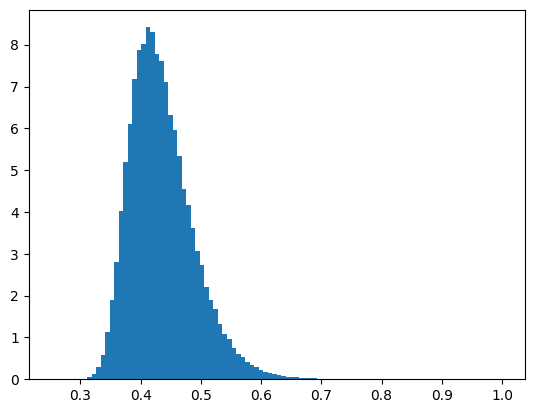

In [30]:
plt.hist(max_iden, bins=100, density=True)

In [32]:
# This distribution is equivalent to a random split with a threshold of 0.55
print("Quantiles:")
for q in [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]:
    print(f"- {q:.2f} quantile: {np.quantile(max_iden, q)}")

Quantiles:
- 0.01 quantile: 0.343505859375
- 0.05 quantile: 0.363037109375
- 0.10 quantile: 0.375
- 0.25 quantile: 0.3974609375
- 0.50 quantile: 0.42822265625
- 0.75 quantile: 0.4658203125
- 0.90 quantile: 0.505859375
- 0.95 quantile: 0.533203125
- 0.99 quantile: 0.59326171875
